In [541]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import seaborn as sn
import random

from tqdm import tqdm

In [542]:
# torch.manual_seed(42)
# np.random.seed(42)

# Define problems
We want to generate data from a standard normal distribution to a normal distribution with mean = 5, std = 5

In [543]:
real_mean, real_std = 8, 1
noise_mean, noise_std = 0, 1

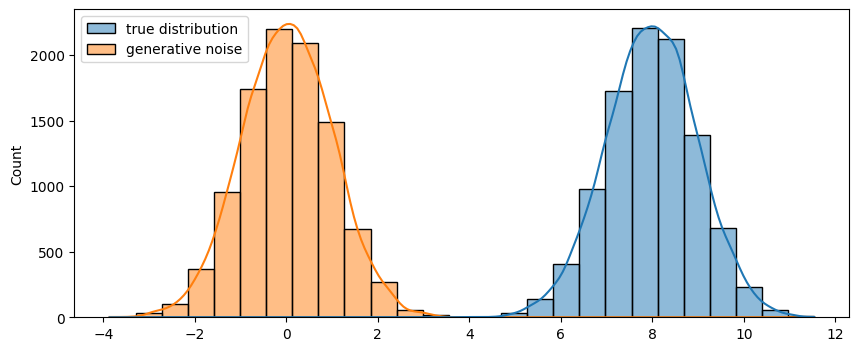

In [555]:
data =  {'true distribution': torch.normal(mean=real_mean, std=real_std, size=(10000,)),
        'generative noise' : torch.normal(mean=noise_mean, std=noise_std, size=(10000,))}

plt.figure(figsize=(10,4))
sn.histplot(data, kde=True)
plt.show()

# Define Discriminator and Generator

In [545]:
class Discriminator(torch.nn.Module):
    def __init__(self, channel_list = [1, 8, 16, 1]):
        super(Discriminator, self).__init__()
        self.discriminator = torch.nn.Sequential()
        for i in range(len(channel_list) - 1):
            self.discriminator.add_module(f'layer_{i}', torch.nn.Linear(in_features=channel_list[i], out_features=channel_list[i+1], bias=True))
            if i != len(channel_list) - 2:
                self.discriminator.add_module(f'activation{i}', torch.nn.ReLU())
    def forward(self, x):
        y = self.discriminator(x)
        return y

In [546]:
class Generator(torch.nn.Module):
    def __init__(self, channel_list = [1, 8, 16, 1]):
        super(Generator, self).__init__()
        self.generator = torch.nn.Sequential()
        for i in range(len(channel_list) - 1):
            self.generator.add_module(f'layer_{i}', torch.nn.Linear(in_features=channel_list[i], out_features=channel_list[i+1], bias=True))
            if i != len(channel_list) - 2:
                self.generator.add_module(f'activation{i}', torch.nn.ReLU())
    def forward(self, x):
        y = self.generator(x)
        return y

# Set up training

In [547]:
generator =     Generator(channel_list = [1, 32, 1])
discriminator = Discriminator(channel_list = [1, 64, 1])

generator_optimizer     = torch.optim.SGD(generator.parameters(), lr=0.001)
discriminator_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.001)

criterion = torch.nn.BCEWithLogitsLoss()

training_steps = 100000
batch_size = 128

# Training

In [548]:
generator_losses = []
discriminator_losses = []

In [549]:
for i in tqdm(range(training_steps), total=training_steps):
    #sample data
    real_data = torch.normal(mean=real_mean, std=real_std, size=(batch_size,1))
    real_label = torch.ones((batch_size,1))
    
    noise = torch.normal(mean=noise_mean, std=noise_std, size=(batch_size,1))
    fake_data = generator(noise)
    fake_label = torch.zeros((batch_size,1))
    
    # train generator
    generator.trainable = True
    discriminator.trainable = False
    generator_optimizer.zero_grad()

    generator_discriminator_out = discriminator(fake_data)

    generator_loss = criterion(generator_discriminator_out, real_label) # D(G(z)) --> 1
    generator_losses.append(generator_loss.item())
    generator_loss.backward()
    generator_optimizer.step()

    # train discriminator
    if i%5 == 0:
        generator.trainable = False
        discriminator.trainable = True
        discriminator_optimizer.zero_grad()

        real_discriminator_out = discriminator(real_data)
        generator_discriminator_out = discriminator(fake_data.detach())

        discriminator_loss = (criterion(real_discriminator_out, real_label) + criterion(generator_discriminator_out, fake_label))/2 # D(G(z)) --> 0 and D(real) --> 1
        discriminator_loss.backward()
        discriminator_optimizer.step()
        discriminator_losses.append(discriminator_loss.item())

100%|██████████| 100000/100000 [02:40<00:00, 623.85it/s]


In [550]:
print(fake_data.mean(), fake_data.std())

tensor(7.9832, grad_fn=<MeanBackward0>) tensor(0.5206, grad_fn=<StdBackward0>)


# Visualize

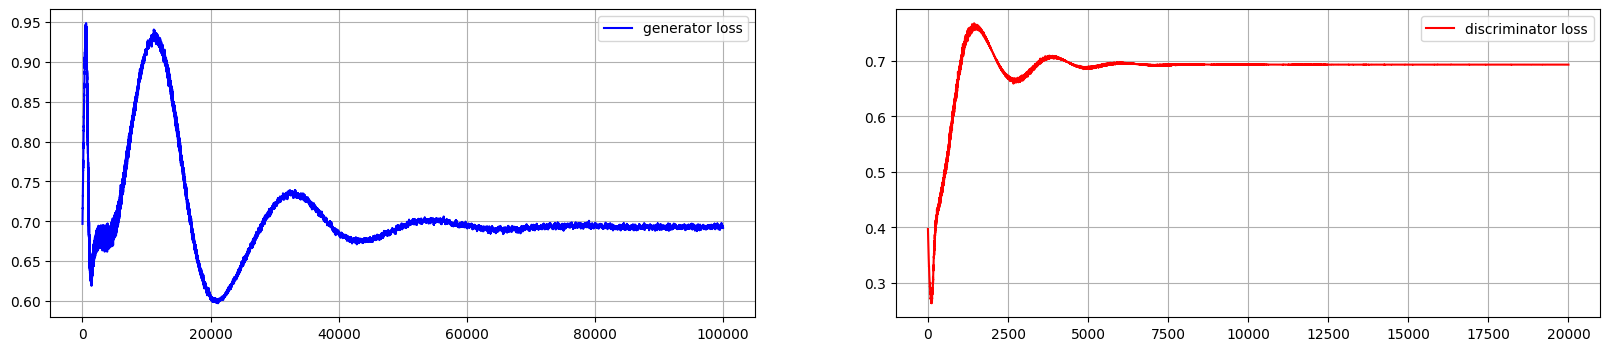

In [551]:
steps = range(training_steps)

plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(range(len(generator_losses)), generator_losses, c='blue', label='generator loss')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(discriminator_losses)), discriminator_losses, c='red', label='discriminator loss')
plt.legend()
plt.grid()
plt.show()


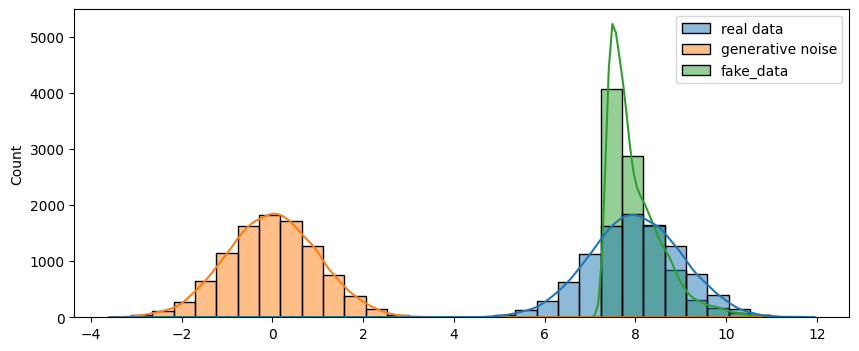

In [552]:
# result
real_data = torch.normal(mean=real_mean, std=real_std, size=(10000,1))
noise = torch.normal(mean=noise_mean, std=noise_std, size=(10000,1))

fake_data = generator(noise).detach().numpy()

data =  {
        'real data': real_data.reshape(-1),
        'generative noise' : noise.reshape(-1),
        'fake_data': fake_data.reshape(-1) 
        }

plt.figure(figsize=(10,4))
sn.histplot(data, kde=True)
plt.show()